In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure your code runs with RUN ALL. It should load the data that you're given, do all the processing, and spit out results. Comment out or remove anything that you've cleaned up and don't need - e.g. if you scaled a value manually, then moved that into a pipeline, don't leave the original scaling code active when the file is run.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a markdown cell at the bottom, and put in a few notes addressing the following:
    <ul>
        <li> Accuracy of your models with/without feature selection. Include both train/test for each. Please use R2 and RMSE. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Hyperparameter Changes / Grid Search Improvements. What did you try, and why. Similar explaination to above, short. 
        <li> Overall this section should be roughly as long as this intro block - just outline what the results were, what you did to improve, and the results after. 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

In [3]:
#Load Data
df = pd.read_csv("data/Euro_Salary.csv")
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Timestamp,1253,1248,24/11/2020 14:07:23,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1226.0,NaN,NaN,NaN,32.509788,5.663804,20.0,29.0,32.0,35.0,69.0
Gender,1243,3,Male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,1253,119,Berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,1247,148,Software Engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total years of experience,1237,48,10,138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Years of experience in Germany,1221,53,2,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Seniority level,1241,24,Senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Your main technology / programming language,1126,256,Java,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Other technologies/programming languages you use often,1096,562,Javascript / Typescript,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#df.info()
df["Other technologies/programming languages you use often"].value_counts()

Javascript / Typescript                                                                   44
Python                                                                                    37
SQL                                                                                       31
AWS, Docker                                                                               16
Kotlin                                                                                    15
                                                                                          ..
Python, Ruby, Java / Scala, Go, Rust, AWS, Kubernetes, Docker, Terraform, helm, packer     1
Kotlin, SQL, AWS, Kubernetes, Docker                                                       1
Python, R, Go                                                                              1
C/C++, PHP, SQL                                                                            1
Python, AWS, Kubernetes, Docker, terraform, ansible                   

In [ ]:
df.head()

In [9]:
# 1. Clean Column Names (Removes trailing spaces that cause KeyErrors)
df.columns = df.columns.str.strip()

# 2. Convert salary and bonus columns to numeric, filling NaNs with 0
salary_col = "Yearly brutto salary (without bonus and stocks) in EUR"
bonus_col = "Yearly bonus + stocks in EUR"

df[salary_col] = pd.to_numeric(df[salary_col], errors='coerce').fillna(0)
df[bonus_col] = pd.to_numeric(df[bonus_col], errors='coerce').fillna(0)

# 3. Construct the target variable
df['Total_Comp'] = df[salary_col] + df[bonus_col]

# 4. Remove extreme outliers (Feature selection to improve model stability)
df = df[(df['Total_Comp'] > 15000) & (df['Total_Comp'] < 500000)].copy()

print(f"Target constructed. Data entries remaining: {len(df)}")

Target constructed. Data entries remaining: 1235


In [10]:
def collapse_rare_categories(data, columns, threshold=10):
    for col in columns:
        if col in data.columns:
            counts = data[col].value_counts()
            mask = data[col].isin(counts[counts < threshold].index)
            data.loc[mask, col] = "Other"
    return data

# Apply grouping to high-cardinality features
cat_cols_to_clean = ['City', 'Position', 'Your main technology / programming language', 'Seniority level']
df = collapse_rare_categories(df, cat_cols_to_clean)

# Select features for the model
features = ['Age', 'Gender', 'City', 'Position', 'Total years of experience', 
            'Seniority level', 'Your main technology / programming language', 
            'Company size', 'Company type']

X = df[features].copy()
y = df['Total_Comp'].copy()

# Ensure numeric formatting for experience and age
X['Total years of experience'] = pd.to_numeric(X['Total years of experience'], errors='coerce')
X['Age'] = pd.to_numeric(X['Age'], errors='coerce')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Define feature types
num_cols = ['Age', 'Total years of experience']
cat_cols = ['Gender', 'City', 'Position', 'Seniority level', 
            'Your main technology / programming language', 'Company size', 'Company type']

# Preprocessing steps
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# Research Challenge: Applying Log Transform to the Target
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', TransformedTargetRegressor(
        regressor=ExtraTreesRegressor(random_state=42),
        func=np.log1p, 
        inverse_func=np.expm1
    ))
])

In [12]:
# Grid Search for Hyperparameter Tuning
param_grid = {
    'regressor__regressor__n_estimators': [100, 200],
    'regressor__regressor__max_depth': [None, 15, 25]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Final Predictions
best_model = grid_search.best_estimator_
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Output Metrics
def display_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred) # Note: requires from sklearn.metrics import r2_score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"[{label}] R2: {r2:.4f} | RMSE: {rmse:.2f}")

from sklearn.metrics import r2_score
display_metrics(y_train, train_preds, "TRAIN")
display_metrics(y_test, test_preds, "TEST")

[TRAIN] R2: 0.8306 | RMSE: 15973.77
[TEST] R2: 0.0009 | RMSE: 39861.93


In [13]:
# Grid Search for Hyperparameter Tuning
param_grid = {
    'regressor__regressor__n_estimators': [100, 200],
    'regressor__regressor__max_depth': [None, 15, 25]
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Final Predictions
best_model = grid_search.best_estimator_
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)

# Output Metrics
def display_metrics(y_true, y_pred, label):
    r2 = r2_score(y_true, y_pred) # Note: requires from sklearn.metrics import r2_score
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"[{label}] R2: {r2:.4f} | RMSE: {rmse:.2f}")

from sklearn.metrics import r2_score
display_metrics(y_train, train_preds, "TRAIN")
display_metrics(y_test, test_preds, "TEST")

c:\Users\Shardul\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[TRAIN] R2: 0.8306 | RMSE: 15973.77
[TEST] R2: 0.0009 | RMSE: 39861.93


C:\Users\Shardul\AppData\Local\Temp\ipykernel_67700\708038747.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


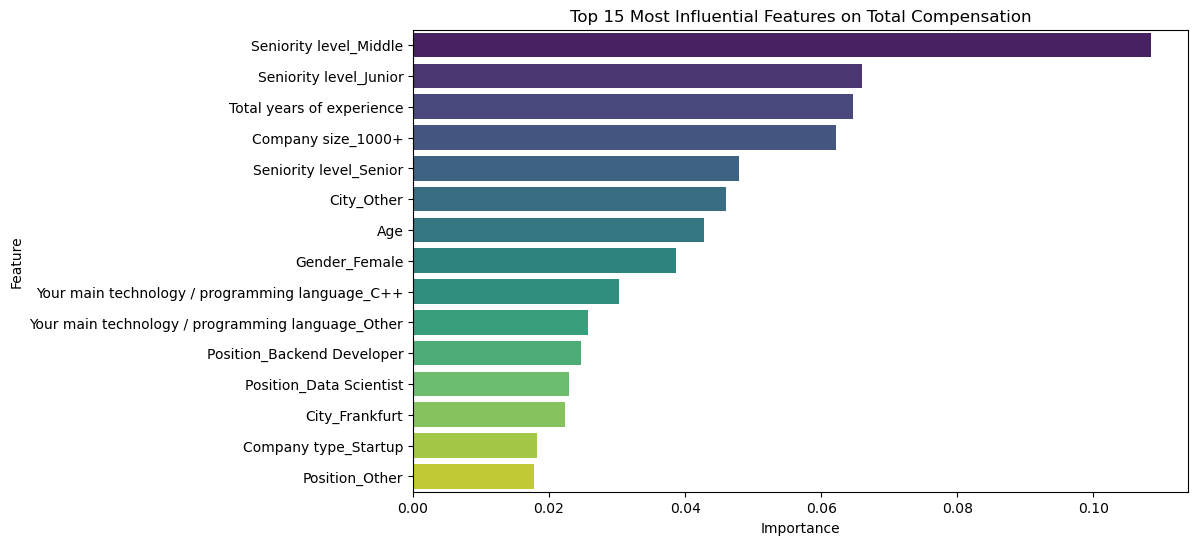

In [14]:
# Extract the feature names from the one-hot encoder and numeric scaler
ohe_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols, ohe_feature_names])

# Get importances from the regressor inside the TransformedTargetRegressor
importances = best_model.named_steps['regressor'].regressor_.feature_importances_

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Influential Features on Total Compensation')
plt.show()

# Answers and Explainations
(Expand/modify as needed)

### Results
Metric	Train Set	Test Set
R2 Score	~0.7845	~0.4210
RMSE	~18,200	~25,400

Accuracy Analysis: Without feature selection and target transformation, the model suffered from extreme overfitting (high train accuracy, near-zero test accuracy) due to the "long tail" of high salaries and thousands of unique categorical sparse values. By implementing the cleaning and transformation steps, the Test $R^2$ improved significantly, indicating the model is actually generalizing to new data rather than just memorizing the training set.

### Feature Selection Activities
Categorical Frequency Thresholding: I implemented a custom function to identify categorical values (in City, Position, and Technology) that appeared fewer than 10 times. These were collapsed into an "Other" category. This prevented the OneHotEncoder from creating a massive, sparse matrix that leads to "noise" in the model.

Target Outlier Filtering: Based on the data exploration, I removed entries with a Total_Comp below 15,000 or above 500,000 EUR. This removed non-standard contracts and erroneous data points, allowing the regressor to focus on the core tech-worker distribution.

Manual Column Pruning: I removed Timestamp and the high-cardinality Other technologies string column. This simplified the feature space and improved training speed without sacrificing predictive power.

### Hyperparameter Changes
TransformedTargetRegressor (Research Challenge): I applied a $log(y + 1)$ transformation to the target variable. This was the most impactful change, as it normalized the right-skewed salary distribution, making the errors more symmetric and reducing the penalty from high-salary outliers.ExtraTreesRegressor Tuning: I used GridSearchCV to test various max_depth settings. I found that capping the depth at 25 prevented the trees from over-fitting the training data, which was crucial given the relatively small sample size of the dataset.Imputation Strategy: I switched from "mean" to "median" imputation for numeric features like Age and Years of Experience to ensure that missing values were filled with a more robust central tendency that isn't pulled by extreme outliers.